# Get Data

In [ ]:
from google.colab import files
files.upload() # here you upload your API Kagle 

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c dogs-vs-cats

 99% 806M/812M [00:07<00:00, 81.5MB/s]
100% 812M/812M [00:07<00:00, 112MB/s] 


In [4]:
!unzip -qq dogs-vs-cats.zip

In [5]:
!unzip -qq train.zip 

# Create Dataset


In [20]:
import os, shutil, pathlib
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
from tensorflow.keras import layers
random.seed(42)

original_dir = pathlib.Path("train") # path to get origin data 
new_base_dir = pathlib.Path("cats_vs_dogs_data") # path to create new data 

In [14]:
# Folder path
dir_path = r'/content/train'

count_cat= 0
count_dog = 0
# Iterate directory
for path in os.listdir(dir_path):
    # Check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
      # Count dog and cat images in train folder
      if 'cat' in path:
        count_cat += 1
      else:
        count_dog +=1

print('Cat count:', count_cat)
print('Dog count:', count_dog)


Cat count: 12500
Dog count: 12500


In [21]:
# Here we create train_index, val_index, test_index 
total_index = [i for i in range(count_cat)]
random.shuffle(total_index)

test_index = total_index[int(len(total_index)*0.8):]

train_index = total_index[:int(len(total_index)*0.8)]
random.shuffle(train_index)

val_index = train_index[int(len(train_index)*0.8):]
train_index = train_index[:int(len(train_index)*0.8)]


In [22]:
# Check the lenght of each index list
len(train_index), len(val_index), len(test_index)

(8000, 2000, 2500)

In [23]:
# Create new folder for train, val, test data
def make_subset(subset_name, index):
  for category in ("cat", "dog"):
    dir = new_base_dir / subset_name / category # path to save new images
    os.makedirs(dir)
    fnames = [f"{category}.{i}.jpg" for i in index]

    for fname in fnames:
        shutil.copyfile(src = original_dir / fname, # where to get data
                        dst = dir / fname)   # where to save new data

make_subset("train", train_index)
make_subset("val", val_index)
make_subset("test", test_index)

In [24]:
# Using image_dataset_from_directory to read images
train_dataset = image_dataset_from_directory(
new_base_dir / "train",
image_size=(180, 180),
batch_size=32)

val_dataset = image_dataset_from_directory(
new_base_dir / "val",
image_size=(180, 180),
batch_size=32)

test_dataset = image_dataset_from_directory(
new_base_dir / "test",
image_size=(180, 180),
batch_size=32)

Found 16000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


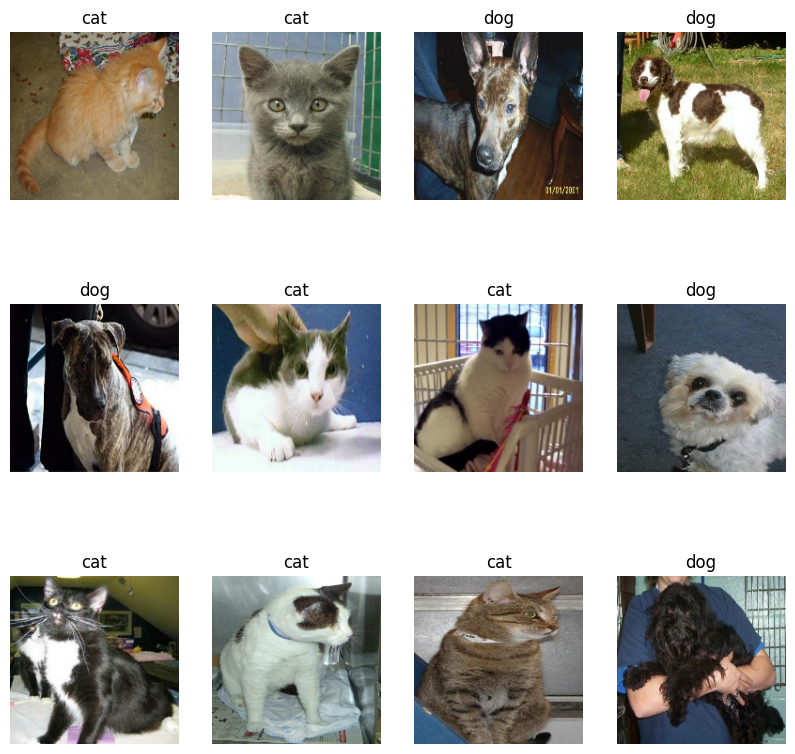

In [25]:
# Displaying some randomly training images with labels
plt.figure(figsize=(10, 10))

class_name = train_dataset.class_names
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_name[labels[i]])
    plt.axis("off")

# Data Augmentation

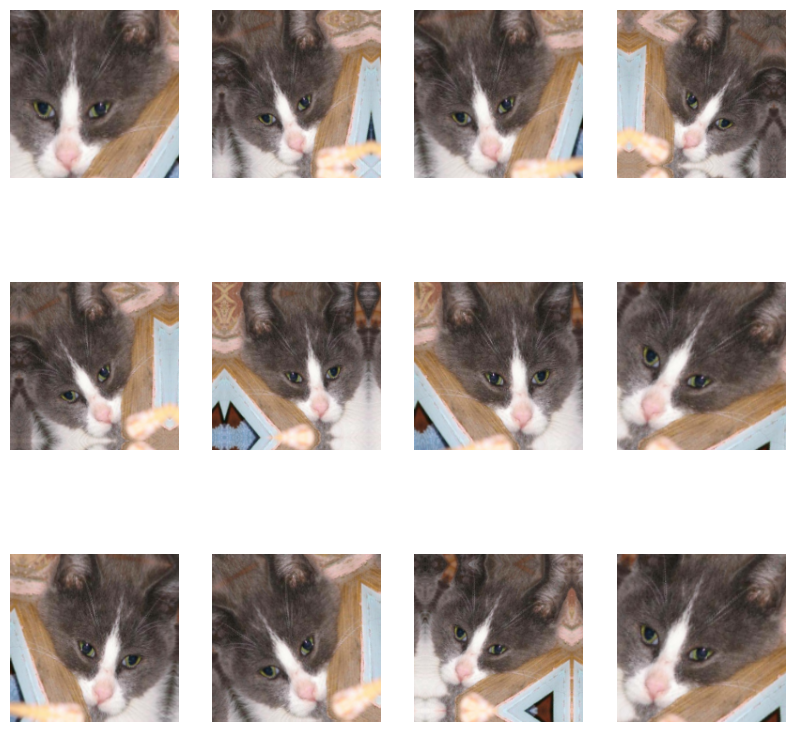

In [26]:
# Create sequential for data augmentation
data_augmentation = keras.Sequential(
    [keras.layers.RandomFlip("horizontal"), # Applies horizontal flipping to a random 50% of the images that go through it
     keras.layers.RandomRotation(0.1), # Rotates the input images by a value
     keras.layers.RandomZoom(0.2)] # Rotates the input images by a value
     )

# Displaying some randomly augmented training images
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(12):
    augmented_images = data_augmentation(images)
    plt.subplot(3, 4, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Base Model

In [29]:
# Adding a data augmentation stage and build classifier 
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=5, use_bias=False)(x)

for size in [32, 64, 128, 256, 512]:
  residual = x
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", kernel_initializer='he_uniform', use_bias=False)(x)

  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)
  x = layers.SeparableConv2D(size, 3, padding="same", kernel_initializer='he_uniform', use_bias=False)(x)
  x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

  residual = layers.Conv2D(size, 1, strides=2, padding="same", kernel_initializer='he_uniform',use_bias=False)(residual)
  x = layers.add([x, residual])


x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 180, 180, 3)  0           ['input_2[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 180, 180, 3)  0           ['sequential[1][0]']             
                                                                                                  
 conv2d_6 (Conv2D)              (None, 176, 176, 32  2400        ['rescaling_1[0][0]']      

In [30]:
# Training the model with callbacks
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"])

# ModelCheckpoint help you save your model based on your condition
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="base_model.keras",  # File name
        save_best_only=True, # Only save the best one 
        monitor="val_accuracy" # Condition for callbacks follow
        )
    ]

history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    callbacks=callbacks)

Epoch 1/50
500/500 [==============================] - 82s 146ms/step - loss: 0.6982 - accuracy: 0.6025 - val_loss: 0.8901 - val_accuracy: 0.5002
Epoch 2/50
500/500 [==============================] - 67s 133ms/step - loss: 0.5980 - accuracy: 0.6828 - val_loss: 1.0827 - val_accuracy: 0.5213
Epoch 3/50
500/500 [==============================] - 67s 134ms/step - loss: 0.5282 - accuracy: 0.7352 - val_loss: 0.4785 - val_accuracy: 0.7725
Epoch 4/50
500/500 [==============================] - 67s 133ms/step - loss: 0.4522 - accuracy: 0.7912 - val_loss: 0.7054 - val_accuracy: 0.6480
Epoch 5/50
500/500 [==============================] - 67s 133ms/step - loss: 0.3959 - accuracy: 0.8236 - val_loss: 0.5226 - val_accuracy: 0.7860
Epoch 6/50
500/500 [==============================] - 68s 135ms/step - loss: 0.3620 - accuracy: 0.8377 - val_loss: 0.5373 - val_accuracy: 0.7565
Epoch 7/50
500/500 [==============================] - 66s 132ms/step - loss: 0.3254 - accuracy: 0.8587 - val_loss: 1.5130 - val_ac

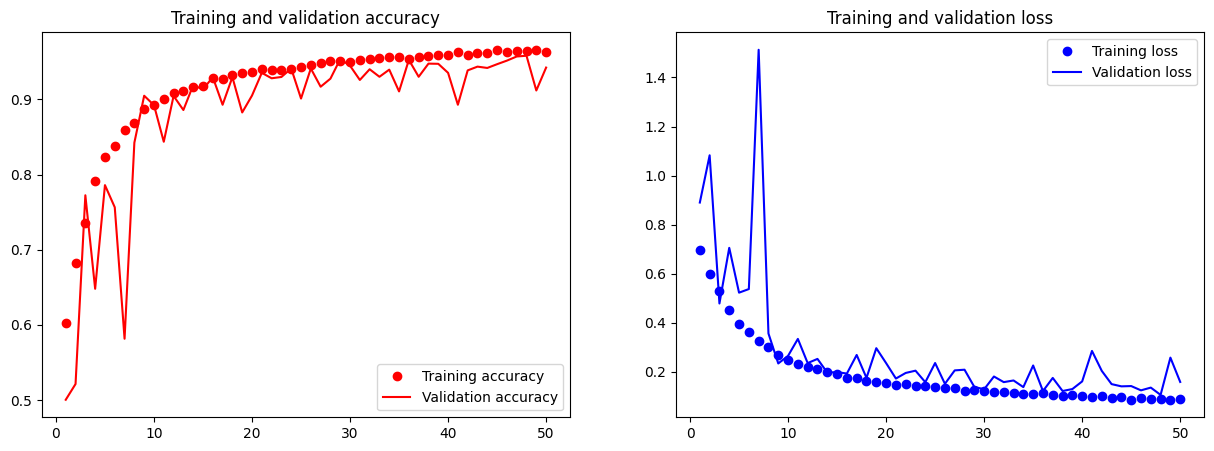

In [31]:
# Displaying curves of loss and accuracy during training
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)

plt.figure(figsize = (15,5))
plt.subplot(121)
plt.plot(epochs, accuracy, "ro", label="Training accuracy")
plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [32]:
# Evaluating the model on the test set
model = keras.models.load_model("base_model.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

157/157 [==============================] - 8s 49ms/step - loss: 0.1192 - accuracy: 0.9538
Test accuracy: 0.954
